In [4]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [5]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


#### 1. 모델 생성

In [95]:
from langchain_google_genai import ChatGoogleGenerativeAI

MODEL_NAME = "gemini-1.5-pro"
# MODEL_NAME = "gemini-pro"
llm = ChatGoogleGenerativeAI(model=MODEL_NAME)

#### 2. 도구 생성 

##### 리서치 팀 도구 생성 
- 웹검색 툴
- 크롤링 툴

In [96]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from tools_tavily import TavilySearch
from langchain_core.tools import tool

# 검색 도구 정의(TavilySearch)
web_search_tool = TavilySearch(max_results=3)


# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    docs = loader.load()

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

#### 3. 에이전트 생성을 위한 유틸리티 함수 생성

에이전트 노드를 생성할때 편리하게 생성하기 위한 유틸리티 함수입니다. 두가지 함수를 정의합니다.
1. `agent` 노드 생성 함수
2. `sub-graph`의 `supervisor` 생성 함수

##### 1. `agent` 노드 생성 함수

In [97]:
from langgraph.graph import END
from langchain_core.messages import HumanMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, SystemMessagePromptTemplate


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, llm):
        self.llm = llm

    def create_agent(self, llm: ChatGoogleGenerativeAI, tools: list, system_prompt: str):
        # Define the system prompt template
        system_prompt_template = PromptTemplate(
            template=system_prompt + 
            """
            if available: \n {agent_history} \n
            """,
            input_variables=["agent_history"],
        )
        
        # Define the system message
        system_message_prompt = SystemMessagePromptTemplate(prompt=system_prompt_template)
        
        print(system_message_prompt)
        
        # Create the prompt template
        prompt = ChatPromptTemplate.from_messages(
            [
                system_message_prompt,
                MessagesPlaceholder(variable_name="messages"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )
        
        # Create the Tool-Calling agent
        agent = create_tool_calling_agent(llm, tools, prompt)
        
        # Wrap the agent in an executor
        executor = AgentExecutor(
            agent=agent,
            tools=tools,
            return_intermediate_steps=True,
            verbose=True  # Set to True for debugging
        )

        return executor
    
    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ],
                "agent_history": result['agent_history'],
            }

        return agent_node

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory(MODEL_NAME)

에이전트 생성 예시

In [85]:
#define system prompt for tool calling agent
system_prompt = """You are a helpful assistant. When the user asks for information or performs a search query, use the `web_search_tool` to retrieve information. Always use the tool for queries related to information retrieval."""
search_agent = agent_factory.create_agent(llm=llm, tools=[web_search_tool], system_prompt=system_prompt)
search_node = agent_factory.create_agent_node(agent=search_agent, name="WebSearcher")

prompt=PromptTemplate(input_variables=['agent_history'], input_types={}, partial_variables={}, template='You are a helpful assistant. When the user asks for information or performs a search query, use the `web_search_tool` to retrieve information. Always use the tool for queries related to information retrieval.\n            if available: \n {agent_history} \n\n            ') additional_kwargs={}


In [94]:
search_agent.invoke({"messages": [{"role": "user", "content": "s&p500 주가는?"}], "agent_scratchpad": {}, "agent_history": []})



> Entering new AgentExecutor chain...

Invoking: `tavily_web_search` with `{'query': 'S&P 500 지수는 얼마입니까?'}`
responded: S&P 500 지수에 대한 최신 정보를 찾으려면 다음을 시도하세요.

[{'title': 'S&P 500 지수 (SPX) - Investing.com', 'url': 'https://kr.investing.com/indices/us-spx-500', 'content': 'S&P 500 지수 (SPX) - Investing.com 미국 달러 지수 지수 S&P 500 차트 주식 차트 지수 차트 인터랙티브 지수 차트 지수 귀하는 과거 데이터, 차트, 기술분석 등과 같은, 이 페이지의 섹션 중 하나로 가서 더 많은 정보를 볼 수 있습니다. 차트 S&P 500의 뉴스 및 분석 S&P 500의 뉴스 및 분석 | Micro S&P 500Dec 24 | 2024년 12월 | 5,928.75 | 5,934.25 | 5,912.00 | +8.75 | +0.15% | 5,928.75+0.15% | 17:25:35 | 360750 TIGER 미국S&P500 | 20,440.00 | +0.05% | 2.64M | 20,440.00+0.05% | 15:19:57 S&P 500 지수 이기기 지수 미국 달러 지수 S&P 500 지수 이기기 S&P 500 지수 이기기 S&P 500 S&P 500 리스크 고지: 금융 상품 및/또는 가상화폐 거래는 투자액의 일부 또는 전체를 상실할 수 있는 높은 리스크를 동반하며, 모든 투자자에게 적합하지 않을 수 있습니다.', 'score': 0.76194656, 'raw_content': 'S&P 500 지수 (SPX) - Investing.com\n\n앱에서 열기\n인기 검색어\n다시 검색해주세요\n최대 55% 할인\n\n로그인\n\n무료 회원가입\n\n\nEnglish (USA)\n\nEnglish (UK)\nEnglish (India)\n

{'messages': [{'role': 'user', 'content': 's&p500 주가는?'}],
 'agent_scratchpad': {},
 'agent_history': [],
 'output': '2025년 1월 16일 현재 S&P 500 지수는 5,937.34입니다.',
 'intermediate_steps': [(ToolAgentAction(tool='tavily_web_search', tool_input={'query': 'S&P 500 지수는 얼마입니까?'}, log="\nInvoking: `tavily_web_search` with `{'query': 'S&P 500 지수는 얼마입니까?'}`\nresponded: S&P 500 지수에 대한 최신 정보를 찾으려면 다음을 시도하세요.\n\n", message_log=[AIMessageChunk(content='S&P 500 지수에 대한 최신 정보를 찾으려면 다음을 시도하세요.', additional_kwargs={'function_call': {'name': 'tavily_web_search', 'arguments': '{"query": "S&P 500 \\uc9c0\\uc218\\ub294 \\uc5bc\\ub9c8\\uc785\\ub2c8\\uae4c?"}'}}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP'}, id='run-bf4b2072-d070-48d9-8036-81cd14fd1ec8', tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'S&P 500 지수는 얼마입니까?'}, 'id': '545c5adc-737c-40e9-8d5a-c659534c8347', 'type': 'tool_call'}], usage_metadata={'input_tokens': 148, 'output_tokens': 48, 'total_tokens': 196, 'input_tok

##### 2. `sub-graph`의 `supervisor` 생성 함수

In [98]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

        
def create_team_supervisor(members: list) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members
    
    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]

    system_prompt = """You are a supervisor tasked with managing a conversation between the
        crew of workers: {members}. Given the following user request, 
        and crew responses respond with the worker to act next.
        Each worker will perform a task and respond with their results and status. 
        When finished with the task, route to FINISH to deliver the result to 
        user. Given the conversation and crew history below, who should act next? Or should we FINISH?
        Select one of: {options} 
    """

    # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_history"),
        ]
    ).partial(options=str(options_for_next), members=str(members))
    
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

##### 문서 작성 팀 도구 생성

- 문서 저장 툴
- 문서 읽는 툴
- 문서 쓰기 및 저장 툴
- 문서 편집 툴
- 코드 실행 도구

In [99]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated
from langchain_experimental.tools import PythonREPLTool

# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")

# tmp 폴더가 없으면 생성
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    # 주어진 파일 이름으로 아웃라인을 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "File path to read the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    # 주어진 파일 이름으로 문서 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "File path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "File path of the edited document."]:
    """Edit a document by inserting text at specific line numbers."""

    # 주어진 파일 이름으로 문서 읽기
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    # 편집된 문서를 파일에 저장
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# PythonREPL 도구
python_repl_tool = PythonREPLTool()

#### 4. 각 에이전트 팀 정의(리서치팀, 문서작성팀) 

##### 리서치 팀

리서치 팀은 `search agent`와 `web scraping`을 담당하는 `research_agent` 라는 두 개의 작업자 노드를 가집니다.

In [100]:
import operator
from typing import TypedDict, Sequence
from typing_extensions import Annotated
from langchain_core.messages import BaseMessage, HumanMessage

# 상태 정의
class ResearchState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지 목록
    next: str  # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시
    agent_history: Annotated[Sequence[BaseMessage], operator.add]  # 에이전트 이력

# 검색 에이전트, 노드 생성
web_search_system_prompt = """You are helpful assistant. Make sure to use the `web_search` tool for searching keyword related info."""
web_search_agent = agent_factory.create_agent(llm=llm, tools=[tavily_tool], system_prompt=web_search_system_prompt)
web_search_node = agent_factory.create_agent_node(agent=web_search_agent, name="WebSearcher")

# 웹 스크래핑 에이전트, 노드 생성
web_scraping_system_prompt = """You are a helpful assistant. Use 'scrape_webpages' to scrape details from web pages."""
web_scraping_agent = agent_factory.create_agent(llm=llm, tools=[scrape_webpages], system_prompt=web_scraping_system_prompt)
web_scraping_node = agent_factory.create_agent_node(
    web_scraping_agent, name="WebScraper"
)

# Supervisor 에이전트 생성
research_team_supervisor_agent = create_team_supervisor(["WebSearcher", "WebScraper"])

prompt=PromptTemplate(input_variables=['agent_history'], input_types={}, partial_variables={}, template='You are helpful assistant. Make sure to use the `web_search` tool for searching keyword related info.\n            if available: \n {agent_history} \n\n            ') additional_kwargs={}
prompt=PromptTemplate(input_variables=['agent_history'], input_types={}, partial_variables={}, template="You are a helpful assistant. Use 'scrape_webpages' to scrape details from web pages.\n            if available: \n {agent_history} \n\n            ") additional_kwargs={}


다음으로 라우팅할 노드를 선택하는 함수를 정의합니다.

In [101]:
def get_next_node(x):
    return x["next"]

다음으로 리서치팀의 엣지를 설정하고 그래프를 컴파일 합니다.

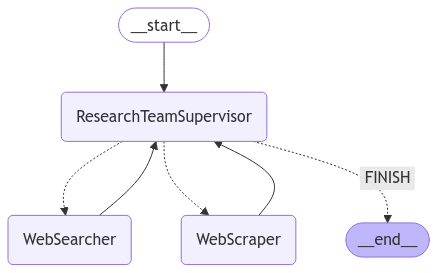

In [102]:
from graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("WebSearcher", web_search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("ResearchTeamSupervisor", research_team_supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("WebSearcher", "ResearchTeamSupervisor")
web_research_graph.add_edge("WebScraper", "ResearchTeamSupervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "ResearchTeamSupervisor",
    get_next_node,
    {"WebSearcher": "WebSearcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("ResearchTeamSupervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

다음으로 그래프를 실행할 수 있는 함수를 구현합니다. 그리고 컴파일된 리서치팀(web_research_app) 을 실행합니다. 테스트입니다.

In [103]:
from langchain_core.runnables import RunnableConfig
from langchain_print import random_uuid, invoke_graph


def run_graph(app, message: str, recursive_limit: int = 5):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [104]:
output = run_graph(
    web_research_app,
    "오늘 S&P500 주가는 얼마입니까?.",
)


🔄 Node: ResearchTeamSupervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebSearcher


> Entering new AgentExecutor chain...

Invoking: `tavily_web_search` with `{'query': 'S&P 500 latest closing price'}`
responded: S&P 500의 최신 종가를 찾으려면 웹 검색을 해야 합니다.

[{'title': 'S&P 500 Realtime Quote - Markets Insider', 'url': 'https://markets.businessinsider.com/index/realtime-chart/s&p_500?op=1', 'content': 'S&P 500 Today: Get all information on the S&P 500 Index including historical chart, news and constituents. ... S&P 500 LIVE QUOTE Last. 5,949.91 +/-107.00 % 1.83%. Trade Time. 04:51:14 PM EDT 1/15', 'score': 0.7557276, 'raw_content': None}, {'title': 'S&P 500 Price, Real-time Quote & News - Google Finance', 'url': 'https://www.google.com/finance/quote/.INX:INDEXSP', 'content': 'Yahoo Finance Stock market today: S&P 500, Nasdaq climb as Tesla shines 27 minutes ago Goodreturns US Market Open Or Closed On Monday, November 18; Weekly Trade Outlook On Dow Jones, S&P 500, Nasdaq 17 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

In [23]:
# 최종 결과 출력
print(output["messages"][-1].content)

Here are some of the major news headlines from Naver Finance:

1. **"배당성향 40%' 현대차증권의 밸류업…소액주주 마음 돌릴 수 있을까"**  
   Source: [비즈워치](https://finance.naver.com/news)

2. **"찬물 끼얹은 투자은행…'테슬라 70% 폭락 예상'"**  
   Source: [한국경제TV](https://finance.naver.com/news)

3. **"'코인 불장' 우르르 몰렸는데 10분 만에 추락…'시세조종' 혐의 검찰 고발"**  
   Source: [머니투데이](https://finance.naver.com/news)

4. **"가상자산 리플 ‘트럼프랠리 첫주자’"**  
   Source: [헤럴드경제](https://finance.naver.com/news)

5. **"환율 불안에 '금리 동결'...다음달 '금리 인하' 무게 [오한마]"**  
   Source: [한국경제TV](https://finance.naver.com/news)

6. **"이게 국장이야, 미장이야[김남석의 개미생활]"**  
   Source: [디지털타임스](https://finance.naver.com/news)

For more details, you can visit the [Naver Finance News page](https://finance.naver.com/news).


##### 문서 작성 팀

`문서 작성`, `차트 생성`, `노트 작성` 등의 노드를 가집니다.

In [24]:
import operator
from typing import List, TypedDict, Annotated
from pathlib import Path


# 임시 디렉토리 생성 및 작업 디렉토리 설정
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)  # tmp 폴더가 없으면 생성


# 상태 정의
class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str  # 현재 작업중인 파일


# 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함
def preprocess(state):
    # 작성된 파일 목록 초기화
    written_files = []

    try:
        # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    # 작성된 파일이 없으면 상태에 "No files written." 추가
    if not written_files:
        return {**state, "current_files": "No files written."}

    # 작성된 파일 목록을 상태에 추가
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME)

# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    state_modifier="You are a arxiv researcher. Your mission is to write arxiv style paper on given topic/resources.",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = agent_factory.create_agent_node(
    context_aware_doc_writer_agent, name="DocWriter"
)

# 노트 작성 노드
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    state_modifier="You are an expert in creating outlines for research papers. Your mission is to create an outline for a given topic/resources or documents.",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = agent_factory.create_agent_node(
    context_aware_note_taking_agent, name="NoteTaker"
)


# 차트 생성 에이전트 생성
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = agent_factory.create_agent_node(
    context_aware_chart_generating_agent, name="ChartGenerator"
)

# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

다음으로 문서 작성 팀의 엣지를 설정하고 그래프를 컴파일 합니다.

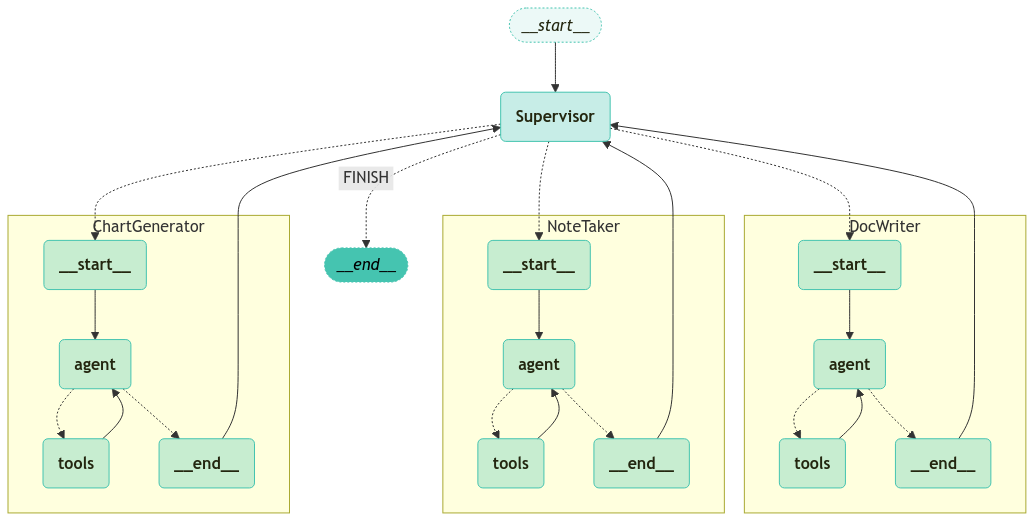

In [25]:
from graphs import visualize_graph

# 그래프 생성
authoring_graph = StateGraph(DocWritingState)

# 노드 정의
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("Supervisor", doc_writing_supervisor)

# 엣지 정의
authoring_graph.add_edge("DocWriter", "Supervisor")
authoring_graph.add_edge("NoteTaker", "Supervisor")
authoring_graph.add_edge("ChartGenerator", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
authoring_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

# 시작 노드 설정
authoring_graph.set_entry_point("Supervisor")

# 그래프 컴파일
authoring_app = authoring_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(authoring_app, xray=True)

#### 5. 계층 추가(상위 supervisor 추가, 총 감독자)

이 설계에서는 상향식 계획 정책을 적용하고 있습니다. 이미 두 개의 그래프를 생성했지만, 이들 간의 작업을 어떻게 라우팅할지 결정해야 합니다.  
  
이를 위해 Super Graph를 정의하여 이전 두 그래프를 조정하고, 이 상위 수준 상태가 서로 다른 그래프 간에 어떻게 공유되는지를 정의하는 연결 요소를 추가할 것입니다.  
  
먼저, 총 감독자 노드를 생성합니다.

In [26]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

# 기본 LLM으로 ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model=MODEL_NAME)

# 팀 감독자 노드 생성
supervisor_node = create_team_supervisor(
    MODEL_NAME,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: ['ResearchTeam', 'PaperWritingTeam']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

#### 6. 결합

다음으로 `Super-Graph` 의 상태와 노드를 정의합니다.

In [27]:
from typing import TypedDict, List, Annotated
import operator


# 상태 정의
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    # 라우팅 결정
    next: str


# 마지막 메시지 반환 노드
def get_last_message(state: State) -> str:
    last_message = state["messages"][-1]
    if isinstance(last_message, str):
        return {"messages": [HumanMessage(content=last_message)]}
    else:
        return {"messages": [last_message.content]}


# 응답 종합 노드
def join_graph(response: dict):
    # 마지막 메시지를 추출하여 메시지 목록으로 반환
    return {"messages": [response["messages"][-1]]}

다음으로 `Super Graph`의 엣지 성정과 그래프를 컴파일합니다.

In [28]:
# 그래프 정의
super_graph = StateGraph(State)

# 노드 정의
super_graph.add_node("ResearchTeam", get_last_message | web_research_app | join_graph)
super_graph.add_node("PaperWritingTeam", get_last_message | authoring_app | join_graph)
super_graph.add_node("Supervisor", supervisor_node)

# 엣지 정의
super_graph.add_edge("ResearchTeam", "Supervisor")
super_graph.add_edge("PaperWritingTeam", "Supervisor")

# 조건부 엣지 추가: Supervisor 의 결정에 따라 다음 노드로 이동
super_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)

# Supervisor 노드를 시작 노드로 설정
super_graph.set_entry_point("Supervisor")

# 그래프 컴파일
super_graph = super_graph.compile(checkpointer=MemorySaver())

시각화합니다.

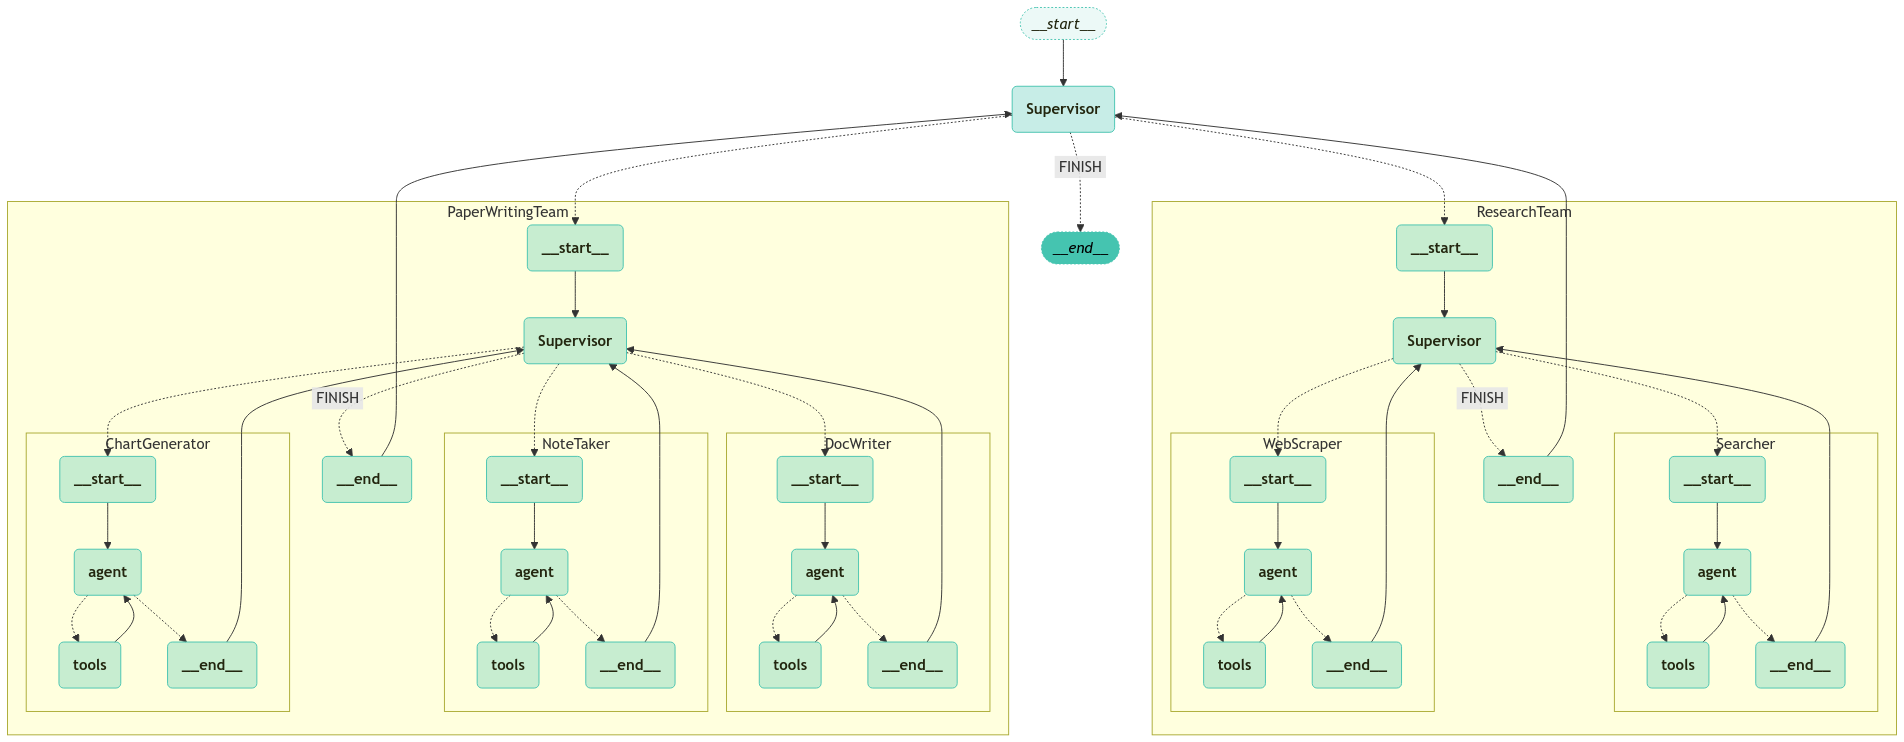

In [29]:
from graphs import visualize_graph

# 그래프 시각화
visualize_graph(super_graph, xray=True)

#### 7. 실행

In [30]:
output = run_graph(
    super_graph,
    """주제: multi-agent 구조를 사용하여 복잡한 작업을 수행하는 방법

상세 가이드라인:  
- 주제에 대한 Arxiv 논문 형식의 리포트 생성
- Outline 생성
- 각각의 Outline 에 대해서 5문장 이상 작성
- 상세내용 작성시 만약 chart 가 필요하면 차트 생성 및 추가
- 한글로 리포트 작성
- 출처는 APA 형식으로 작성
- 최종 결과는 .md 파일로 저장""",
    recursive_limit=150,
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
ResearchTeam

🔄 Node: Supervisor in [ResearchTeam] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Searcher

🔄 Node: agent in [Searcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

# Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## 목차
1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 방법론
6. 결론
7. 참고문헌

---

## 1. 서론
Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능 및 로봇공학의 발전과 함께 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 리포트에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 방법론을 제시합니다.

## 2. Multi-Agent 시스템의 개요
Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 분산형 시스템입니다. 각 에이전트는 독립적인 프로세서로서 특정한 목표를 가지고 있으며,

In [31]:
from IPython.display import Markdown

if hasattr(output["messages"][-1], "content"):
    display(Markdown(output["messages"][-1].content))
else:
    display(Markdown(output["messages"][-1]))

위의 내용을 기반으로 Markdown 형식의 리포트를 생성하였습니다. 아래는 해당 리포트의 내용입니다.

```markdown
# Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## 목차
1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 방법론
6. 결론
7. 참고문헌

---

## 1. 서론
Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능 및 로봇공학의 발전과 함께 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 리포트에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 방법론을 제시합니다.

## 2. Multi-Agent 시스템의 개요
Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 분산형 시스템입니다. 각 에이전트는 독립적인 프로세서로서 특정한 목표를 가지고 있으며, 다른 에이전트와의 협력을 통해 더 큰 목표를 달성합니다. 이러한 시스템은 분산 컴퓨팅, 네트워크, 인공지능 등 다양한 기술의 융합으로 이루어집니다. Multi-Agent 시스템은 특히 복잡한 문제를 해결하는 데 유리하며, 각 에이전트의 자율성과 협력 능력이 중요한 역할을 합니다. 이러한 시스템의 설계와 구현은 다양한 분야에서 연구되고 있으며, 그 응용 범위는 점차 확대되고 있습니다.

## 3. Multi-Agent 구조의 장점
Multi-Agent 시스템의 주요 장점 중 하나는 확장성입니다. 시스템에 새로운 에이전트를 추가하는 것이 비교적 용이하며, 이를 통해 시스템의 기능을 확장할 수 있습니다. 또한, 각 에이전트가 독립적으로 작동하기 때문에 시스템의 신뢰성과 내구성이 향상됩니다. 에이전트 간의 협력은 문제 해결의 효율성을 높이며, 복잡한 작업을 분할하여 처리할 수 있게 합니다. 이러한 구조는 특히 대규모 데이터 처리, 복잡한 의사결정, 실시간 반응이 필요한 작업에 적합합니다. Multi-Agent 시스템은 또한 다양한 환경 변화에 유연하게 대응할 수 있는 능력을 제공합니다.

## 4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
Multi-Agent 시스템은 다양한 분야에서 복잡한 작업을 해결하는 데 사용됩니다. 예를 들어, 물류 및 공급망 관리에서 여러 로봇이 협력하여 물품을 이동시키는 작업에 활용됩니다. 또한, 금융 분야에서는 여러 에이전트가 시장 데이터를 분석하고 거래 전략을 수립하는 데 사용됩니다. 이러한 시스템은 또한 스마트 그리드에서 에너지 분배를 최적화하는 데 기여합니다. 각 에이전트는 실시간 데이터를 기반으로 의사결정을 내리며, 전체 시스템의 효율성을 극대화합니다. 이러한 사례들은 Multi-Agent 시스템의 실용성과 효과를 잘 보여줍니다.

## 5. Multi-Agent 시스템 설계 방법론
Multi-Agent 시스템을 설계할 때는 각 에이전트의 역할과 상호작용을 명확히 정의하는 것이 중요합니다. 에이전트의 자율성과 협력 메커니즘을 고려하여 시스템의 구조를 설계해야 합니다. 또한, 에이전트 간의 통신 프로토콜과 데이터 교환 방식을 설계하는 것이 필수적입니다. 시스템의 성능을 평가하기 위해 시뮬레이션 및 테스트를 통해 다양한 시나리오를 검증해야 합니다. 이러한 설계 과정은 시스템의 목표와 환경에 따라 다르게 적용될 수 있으며, 지속적인 개선과 최적화가 필요합니다.

## 6. 결론
Multi-Agent 시스템은 복잡한 작업을 효율적으로 해결할 수 있는 강력한 도구입니다. 이러한 시스템은 다양한 분야에서 그 유용성을 입증하고 있으며, 앞으로도 그 응용 범위는 더욱 확대될 것입니다. Multi-Agent 시스템의 설계와 구현은 기술적 도전과제를 포함하지만, 그 잠재적 이점은 매우 큽니다. 본 리포트에서는 Multi-Agent 구조의 이론적 배경과 실제 적용 사례를 통해 그 가능성을 탐구하였습니다. 앞으로의 연구는 이러한 시스템의 성능을 더욱 향상시키고, 새로운 응용 분야를 개척하는 데 기여할 것입니다.

## 7. 참고문헌
- Jennings, N. R., & Wooldridge, M. (1998). Applications of intelligent agents. In Agent technology (pp. 3-28). Springer, Berlin, Heidelberg.
- Weiss, G. (Ed.). (1999). Multiagent systems: a modern approach to distributed artificial intelligence. MIT press.
- Russell, S., & Norvig, P. (2009). Artificial Intelligence: A Modern Approach. Prentice Hall.
```

이 내용을 `.md` 파일로 저장하시면 됩니다.

In [32]:
print(output["messages"][-1])

위의 내용을 기반으로 Markdown 형식의 리포트를 생성하였습니다. 아래는 해당 리포트의 내용입니다.

```markdown
# Arxiv 논문 형식 리포트: Multi-Agent 구조를 사용하여 복잡한 작업을 수행하는 방법

## 목차
1. 서론
2. Multi-Agent 시스템의 개요
3. Multi-Agent 구조의 장점
4. 복잡한 작업에서의 Multi-Agent 시스템 적용 사례
5. Multi-Agent 시스템 설계 방법론
6. 결론
7. 참고문헌

---

## 1. 서론
Multi-Agent 시스템은 여러 개의 독립적인 에이전트가 협력하여 복잡한 문제를 해결하는 구조를 의미합니다. 이러한 시스템은 각 에이전트가 독립적으로 작동하면서도 상호작용을 통해 전체 시스템의 목표를 달성할 수 있도록 설계됩니다. 최근 인공지능 및 로봇공학의 발전과 함께 Multi-Agent 시스템은 다양한 분야에서 주목받고 있습니다. 본 리포트에서는 Multi-Agent 구조를 활용하여 복잡한 작업을 수행하는 방법에 대해 논의하고자 합니다. 이를 통해 Multi-Agent 시스템의 이론적 배경과 실제 적용 사례를 살펴보고, 설계 방법론을 제시합니다.

## 2. Multi-Agent 시스템의 개요
Multi-Agent 시스템은 여러 개의 에이전트가 상호작용하여 문제를 해결하는 분산형 시스템입니다. 각 에이전트는 독립적인 프로세서로서 특정한 목표를 가지고 있으며, 다른 에이전트와의 협력을 통해 더 큰 목표를 달성합니다. 이러한 시스템은 분산 컴퓨팅, 네트워크, 인공지능 등 다양한 기술의 융합으로 이루어집니다. Multi-Agent 시스템은 특히 복잡한 문제를 해결하는 데 유리하며, 각 에이전트의 자율성과 협력 능력이 중요한 역할을 합니다. 이러한 시스템의 설계와 구현은 다양한 분야에서 연구되고 있으며, 그 응용 범위는 점차 확대되고 있습니다.

## 3. Multi-Agent 구조의 장점
Multi-Agent 시스템의 주요 장점 중 하나는 확장성입니다. 시스템에 새로운 에이